In [1]:
# Install dggs library for regridding
#%pip install git+https://github.com/IAOCEA/xarray-healpy.git xdggs

In [2]:
import s3fs # For accessing file storage at Amazon S3
import xarray as xr # N-dimensional arrays with dimension, coordinate and attribute labels
from xarray_healpy import HealpyGridInfo, HealpyRegridder
import numpy as np

In [3]:
# Extract file from S3
client_kwargs={'endpoint_url': 'https://pangeo-eosc-minioapi.vm.fedcloud.eu/'}
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=client_kwargs)

filename_ocean = "s3://afouilloux-fair2adapt/10.11582_2024.00093/N1850_f19_tn14_20190722/ocn/hist/N1850_f19_tn14_20190722.micom.hbgcd.1801-01.nc"
filename_atmosphere = "s3://afouilloux-fair2adapt/10.11582_2024.00093/N1850_f19_tn14_20190722/atm/hist/N1850_f19_tn14_20190722.cam.h0.1801-01.nc"

In [4]:
#ocean_ds = xr.open_dataset(s3.open(filename_ocean))
#ocean_ds

In [5]:
# Example visualization of srfdissic (Surface concentration of dissolved inorganic carbon) 
#ocean_ds.srfdissic.isel(time=0).plot()

In [6]:
# Opening the atmosphere ds typically takes a few minutes
atmosphere_ds = xr.open_dataset(s3.open(filename_atmosphere))
atmosphere_ds

<xarray.Dataset> Size: 583MB
Dimensions:               (lat: 96, zlon: 1, nbnd: 2, lon: 144, lev: 32,
                           ilev: 33, time: 1)
Coordinates:
  * lat                   (lat) float64 768B -90.0 -88.11 -86.21 ... 88.11 90.0
  * zlon                  (zlon) float64 8B 0.0
  * lon                   (lon) float64 1kB 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * lev                   (lev) float64 256B 3.643 7.595 14.36 ... 976.3 992.6
  * ilev                  (ilev) float64 264B 2.255 5.032 10.16 ... 985.1 1e+03
  * time                  (time) object 8B 1801-02-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/1194)
    zlon_bnds             (zlon, nbnd) float64 16B ...
    gw                    (lat) float64 768B ...
    hyam                  (lev) float64 256B ...
    hybm                  (lev) float64 256B ...
    P0                    float64 8B ...
    hyai                  (ilev) float64 264B ...
    ...                    ...
    mmr_OM                (time, lev, lat, lon) float32 2MB ...
    mmr_SALT              (time, lev, lat, lon) float32 2MB ...
    mmr_SULFATE           (time, lev, lat, lon) float32 2MB ...
    monoterp              (time, lev, lat, lon) float32 2MB ...
    monoterp_SRF          (time, lat, lon) float32 55kB ...
    ozone                 (time, lev, lat, lon) float32 2MB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              N1850_f19_tn14_20190722
    logname:           olivie
    host:              
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

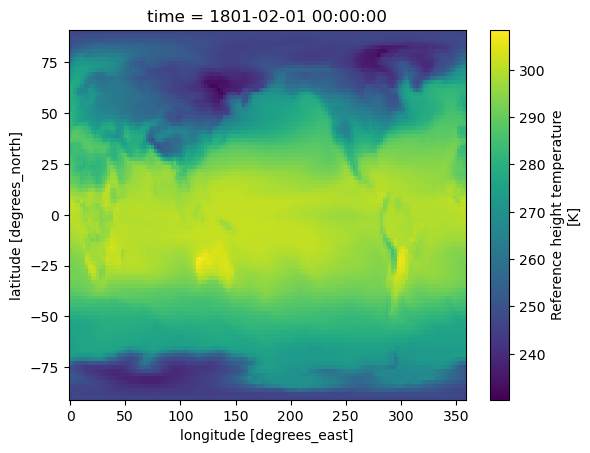

In [7]:
# Plot reference height temperature (TREFHT)
atmosphere_ds.TREFHT.isel(time=0).plot()

In [9]:
# Standardize coordinate names 
ds = atmosphere_ds
ds["lat"] = ds["lat"].assign_attrs(standard_name="latitude")
ds["lon"] = ds["lon"].assign_attrs(standard_name="longitude")
ds = ds.rename_vars({"lat": "latitude", "lon": "longitude"})
ds = ds.merge(ds[["latitude", "longitude"]].compute() )
ds

<xarray.Dataset> Size: 583MB
Dimensions:               (lat: 96, zlon: 1, nbnd: 2, lon: 144, lev: 32,
                           ilev: 33, time: 1)
Coordinates:
  * latitude              (lat) float64 768B -90.0 -88.11 -86.21 ... 88.11 90.0
  * zlon                  (zlon) float64 8B 0.0
  * longitude             (lon) float64 1kB 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * lev                   (lev) float64 256B 3.643 7.595 14.36 ... 976.3 992.6
  * ilev                  (ilev) float64 264B 2.255 5.032 10.16 ... 985.1 1e+03
  * time                  (time) object 8B 1801-02-01 00:00:00
Dimensions without coordinates: lat, nbnd, lon
Data variables: (12/1194)
    zlon_bnds             (zlon, nbnd) float64 16B ...
    gw                    (lat) float64 768B ...
    hyam                  (lev) float64 256B ...
    hybm                  (lev) float64 256B ...
    P0                    float64 8B ...
    hyai                  (ilev) float64 264B ...
    ...                    ...
    mmr_OM                (time, lev, lat, lon) float32 2MB ...
    mmr_SALT              (time, lev, lat, lon) float32 2MB ...
    mmr_SULFATE           (time, lev, lat, lon) float32 2MB ...
    monoterp              (time, lev, lat, lon) float32 2MB ...
    monoterp_SRF          (time, lat, lon) float32 55kB ...
    ozone                 (time, lev, lat, lon) float32 2MB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              N1850_f19_tn14_20190722
    logname:           olivie
    host:              
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [10]:
# Regrid temperature to DGGS 
level = 4                       # Healpix level
nside = level**2                # Each side of the original 12 faces in Healpix is divided into nside parts 
number_of_cells = 12*nside**2   # The resulting total number of cells

min_vertices = 1                # Minimum number of vertices for a valid transcription for regridding.
                                # 1 is the most liberal, meaning that only one is needed 

print("Level:", level)
print("nside:", nside)
print("Number of cells:", number_of_cells)

Level: 4
nside: 16
Number of cells: 3072


In [11]:
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180

    return ds.assign_coords(longitude=centered)

In [12]:
%%time
# Define the target Healpix grid information
grid = HealpyGridInfo(level=level)
target_grid = grid.target_grid(ds).pipe(center_longitude, 0)
target_grid

CPU times: user 758 ms, sys: 64 ms, total: 822 ms
Wall time: 823 ms


<xarray.Dataset> Size: 71kB
Dimensions:     (cells: 2961)
Coordinates:
    cell_ids    (cells) uint64 24kB 0 1 2 3 4 5 ... 3067 3068 3069 3070 3071
    latitude    (cells) float64 24kB 2.388 4.78 4.78 ... -4.78 -4.78 -2.388
    longitude   (cells) float64 24kB 45.0 47.81 42.19 ... -42.19 -47.81 -45.0
    resolution  float64 8B 0.06396
Dimensions without coordinates: cells
Data variables:
    *empty*
Attributes:
    grid_type:  healpix
    level:      4
    nside:      16
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

In [ ]:
%%time
# Compute the interpolation weights for regridding the diff data
regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={},
)
regridder

In [ ]:
%%time
# Perform the regridding operation using the computed interpolation weights.
regridded = regridder.regrid_ds(ds).pipe(xdggs.decode)